# TalkingData Mobile User Demographics - 3rd place solution

In this competition, Kagglers are challenged to build a model predicting users’ demographic characteristics based on their app usage, geolocation, and mobile device properties. Doing so will help millions of developers and brand advertisers around the world pursue data-driven marketing efforts which are relevant to their users and catered to their preferences.

https://www.kaggle.com/c/talkingdata-mobile-user-demographics

## 1.- Overview of the data

### gender_age_train.csv, gender_age_test.csv -- the training and test set

Variable to predict: Group


In [11]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [13, 7]

train shape: (74645, 3), test shape: (112071, 0)
                     gender  age   group
device_id                               
-8076087639492063270      M   35  M32-38
-2897161552818060146      M   35  M32-38
-8260683887967679142      M   35  M32-38
-4938849341048082022      M   30  M29-31
 245133531816851882       M   30  M29-31


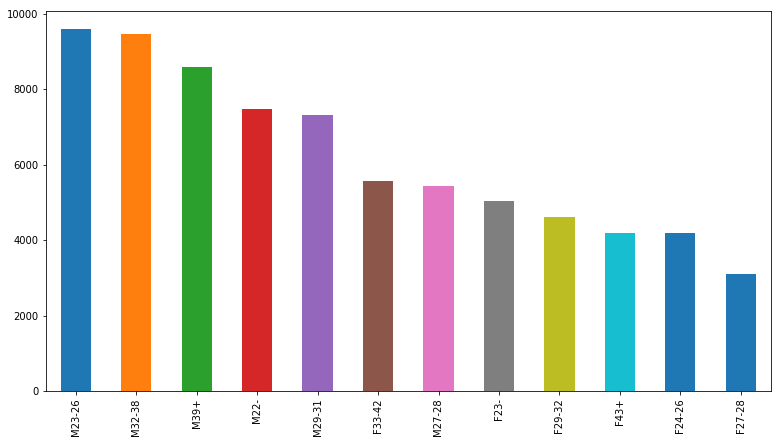

In [54]:
datadir = '../input'
gatrain = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'), index_col='device_id')
gatest = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'), index_col = 'device_id')
print('train shape: {}, test shape: {}'.format(gatrain.shape, gatest.shape))
print(gatrain.head())
gatrain['group'].value_counts().plot.bar()


### Brands and model

In [55]:
phone = pd.read_csv(os.path.join(datadir,'phone_brand_device_model.csv'))
phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id')
print(phone.shape)
phone.head()

(186716, 2)


,phone_brand,device_model
device_id,,
-8890648629457979026,小米,红米
1277779817574759137,小米,MI 2
5137427614288105724,三星,Galaxy S4
3669464369358936369,SUGAR,时尚手机
-5019277647504317457,三星,Galaxy Note 2


### Events, AppEvents, and labels

In [56]:
events = pd.read_csv(os.path.join(datadir,'events.csv'),  parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv(os.path.join(datadir,'app_events.csv'), usecols=['event_id','app_id','is_active'], dtype={'is_active':bool})
applabels = pd.read_csv(os.path.join(datadir,'app_labels.csv'))
labelcategories = pd.read_csv(os.path.join(datadir, 'label_categories.csv'))
print('evnets shape: {}, appevents shape: {}, applabels shape: {}'.format(events.shape, appevents.shape, applabels.shape))

/home/dragon/kaggle/talking_data/brussels/venv/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


evnets shape: (3252950, 4), appevents shape: (32473067, 3), applabels shape: (459943, 2)


In [4]:
events[events['device_id']==-6401643145415154744].head()  # One device, many events

,device_id,timestamp,longitude,latitude
event_id,,,,
2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
17185,-6401643145415154744,2016-05-01 16:04:52,103.65,30.97
17187,-6401643145415154744,2016-05-01 16:09:45,103.65,30.97
41213,-6401643145415154744,2016-05-01 11:25:59,103.65,30.97
65269,-6401643145415154744,2016-05-01 00:51:34,103.65,30.97


In [5]:
appevents[appevents['event_id'] == 2]  # When an event happened, what apps were installed in the device?

,event_id,app_id,is_active
0,2,5927333115845830913,True
1,2,-5720078949152207372,False
2,2,-1633887856876571208,False
3,2,-653184325010919369,True
4,2,8693964245073640147,True
5,2,4775896950989639373,True
6,2,-8022267440849930066,False
7,2,9112463267739110219,False
8,2,-3725672010020973973,False
9,2,7167114343576723123,True


In [6]:
applabels.head()  # apps have labels

,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [7]:
labelcategories.head()  # labels are not very well normalised. They werent very useful for us

,label_id,category
0,1,NaN
1,2,game-game type
2,3,game-Game themes
3,4,game-Art Style
4,5,game-Leisure time


### Proportion of devices with data in events

Proportion of devices with events: 0.3122647196731194


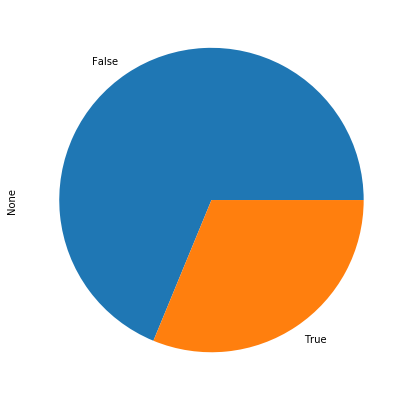

In [14]:
has_events = np.in1d(gatrain.index.values, events['device_id'].values)
pd.Series(has_events).value_counts().plot.pie()
print('Proportion of devices with events: {}'.format(has_events.mean()))

**KEY: We used different models for these 2 groups**

## 2.- Feature Engineering

In [15]:
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import LabelEncoder

### One Hot Encoding with sparse matrices

In [16]:
def get_sparse_data(train, test, col):
    """ A sparse matrix of features can be constructed using the csr_matrix constructor:
        csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
        where "data", "row_ind" and "col_ind" satisfy the
        relationship "a[row_ind[k], col_ind[k]] = data[k]""
    """
    full = pd.concat([train[col], test[col]], axis=0)
    full = full.fillna(-9999)
    appencoder = LabelEncoder().fit(full)
    train[col] = appencoder.transform(train[col])
    test[col] = appencoder.transform(test[col])
    nvalues = len(appencoder.classes_)

    xtr = csr_matrix(
        (np.ones(len(train)), (train.trainrow, train[col])),
        shape=(train.shape[0], nvalues))

    xte = csr_matrix(
        (np.ones(len(test)), (test.testrow, test[col])),
        shape=(test.shape[0], nvalues))
    assert np.sum(xtr) == len(train)
    assert np.sum(xte) == len(test)
    return xtr, xte

# Example:
gatrain["trainrow"] = np.arange(gatrain.shape[0])
gatest["testrow"] = np.arange(gatest.shape[0])

gatrain['model'] = phone["device_model"]
gatest['model'] = phone["device_model"]
xtrain, xtest = get_sparse_data(gatrain, gatest, 'model')

In [17]:
xtrain

<74645x1599 sparse matrix of type '<class 'numpy.float64'>'
	with 74645 stored elements in Compressed Sparse Row format>

### Now, using a grouped column

In [18]:
def get_sparse_from_grouped(train, test, trans, col):
    """ 
    Example:
    Remember that there are many events for each device.
    for each device I want to mark which event id was purchased with
    I'll have as many event values columns as events are linked to devices    
    """
    trans[col] = trans[col].fillna(-9999)
    appencoder = LabelEncoder().fit(trans[col])
    trans[col] = appencoder.transform(trans[col])
    nvalues = len(appencoder.classes_)

    aggtable = (
        trans.groupby(['device_id', col])['device_id']
        .agg(['count'])
        .merge(train[['trainrow']], how='left', left_index=True, right_index=True)
        .merge(test[['testrow']], how='left', left_index=True, right_index=True)
        .reset_index()
    )
    temp = aggtable.dropna(subset=['trainrow'])
    xtr = csr_matrix(
        (np.ones(len(temp)).astype(float), (temp.trainrow, temp[col])),
        shape=(train.shape[0], nvalues))

    temp = aggtable.dropna(subset=['testrow'])
    xte = csr_matrix(
        (np.ones(len(temp)).astype(float), (temp.testrow, temp[col])),
        shape=(test.shape[0], nvalues))
    assert xtr.shape[0] == len(train)
    assert xte.shape[0] == len(test)
    return xtr, xte

# Example: 
transactions = appevents.merge(
    events[["device_id"]], how="left", left_on="event_id", right_index=True
)
print('shape of apps in devices: {}'.format(transactions.shape))
print(transactions.head())
xtrain, xtest = get_sparse_from_grouped(gatrain, gatest, transactions, 'app_id')

shape of apps in devices: (32473067, 4)
   event_id               app_id  is_active            device_id
0         2  5927333115845830913       True -6401643145415154744
1         2 -5720078949152207372      False -6401643145415154744
2         2 -1633887856876571208      False -6401643145415154744
3         2  -653184325010919369       True -6401643145415154744
4         2  8693964245073640147       True -6401643145415154744


In [20]:
xtrain

<74645x19237 sparse matrix of type '<class 'numpy.float64'>'
	with 915632 stored elements in Compressed Sparse Row format>

### Bag of brands and labels

#### For each APP, we list all the labels

In [70]:
app_lab = pd.read_csv(os.path.join(datadir,'app_labels.csv'))
app_lab = app_lab.groupby("app_id")["label_id"].apply(
    lambda x: " ".join(str(s) for s in x)
)

In [59]:
app_lab.head()

app_id
-9223281467940916832                796 795 794 405
-9222877069545393219                            135
-9222785464897897681                812 795 794 405
-9222198347540756780                810 795 794 405
-9221970424041518544    714 704 548 813 795 794 405
Name: label_id, dtype: object

#### For each EVENT, list all labels

In [60]:
appevents["app_lab"] = appevents["app_id"].map(app_lab)
appevents = appevents.groupby("event_id")["app_lab"].apply(
    lambda x: " ".join(str(s) for s in x)
)

In [61]:
appevents.head()

event_id
2     549 710 704 548 172 721 704 548 302 303 251 26...
6     549 721 704 302 303 548 183 713 704 548 549 71...
7     549 721 704 548 548 549 186 721 704 548 303 30...
9     549 721 704 302 303 548 183 549 721 704 548 40...
16    549 721 704 302 303 548 183 549 713 704 405 54...
Name: app_lab, dtype: object

In [62]:
events["app_lab"] = events.index.map(appevents)
events = events.groupby("device_id")["app_lab"].apply(
    lambda x: " ".join(str(s) for s in x)
)

In [63]:
events.head()

device_id
-9222956879900151005    959 960 548 1007 959 960 548 1007 959 960 548 ...
-9222661944218806987    721 704 548 232 711 714 548 704 813 795 794 40...
-9222399302879214035    549 710 704 303 318 306 302 548 843 840 169 27...
-9221825537663503111    nan nan nan nan nan nan nan nan 1012 808 795 7...
-9221767098072603291    549 710 704 548 172 721 704 548 302 303 713 70...
Name: app_lab, dtype: object

#### Copy the values to train and test

In [64]:
gatrain["app_lab"] = gatrain.index.map(events)
gatest["app_lab"] = gatest.index.map(events)

In [65]:
gatrain.head(20)

,gender,age,group,app_lab
device_id,,,,
-8076087639492063270,M,35,M32-38,NaN
-2897161552818060146,M,35,M32-38,NaN
-8260683887967679142,M,35,M32-38,713 704 548 713 704 548 163 158 551 552 555 55...
-4938849341048082022,M,30,M29-31,NaN
245133531816851882,M,30,M29-31,NaN
-1297074871525174196,F,24,F24-26,NaN
236877999787307864,M,36,M32-38,NaN
-8098239495777311881,M,38,M32-38,NaN
176515041953473526,M,33,M32-38,NaN


In [66]:
gatrain["app_lab"] = gatrain.index.map(events)
gatest["app_lab"] = gatest.index.map(events)

In [72]:
gatrain['device_model'] = phone['device_model']
gatrain['phone_brand'] = phone['phone_brand']

gatest['device_model'] = phone['device_model']
gatest['phone_brand'] = phone['phone_brand']

#### Calculate TF-IDF sparse matrix

In [77]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def get_hash_data(train, test):
    df = pd.concat((train, test), axis=0, ignore_index=True, sort=True)
    split_len = len(train)
    tfv = TfidfVectorizer(min_df=1)
    df = (
        df[["phone_brand", "device_model", "app_lab"]]
        .astype(np.str)
        .apply(lambda x: " ".join(s for s in x), axis=1)
        .fillna("Missing")
    )
    df_tfv = tfv.fit_transform(df)
    train = df_tfv[:split_len, :]
    test = df_tfv[split_len:, :]
    return train, test

train_bag, test_bag = get_hash_data(gatrain, gatest)

In [78]:
train_bag

<74645x2045 sparse matrix of type '<class 'numpy.float64'>'
	with 1878613 stored elements in Compressed Sparse Row format>

In [94]:
train_bag[210:220, 5:10].todense()

matrix([[0.03703429, 0.        , 0.        , 0.01039728, 0.02726156],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.04779276, 0.        , 0.        , 0.036018  , 0.04560046],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.09440759, 0.04919609, 0.        , 0.0155441 , 0.0427943 ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.0167718 , 0.02767616, 0.        , 0.15740313, 0.03209961],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.03622585, 0.        , 0.        , 0.11332637, 0.03466639]])

## 3 .- Optimization Variant